In [1]:
from larch.xafs import feffit, feffit_dataset, feffit_transform, feffit_report
from larch.xafs import pre_edge, autobk, xftf, xftr, ff2chi, feffpath
from larch.fitting import  param_group, param
from larch.io import h5group, read_ascii, read_athena, read_xdi, read_specfile, extract_athenagroup

import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

[root] WARNING : Larchs apps and shell are not supported due to missing dependencies: cannot import name 'LarchWxApp' from 'larch.wxlib' (D:\Python\Anaconda3\envs\xraylarch\lib\site-packages\larch\wxlib\__init__.py)


In [ ]:
"""
Plan

1. Organise Cu Standard scripts. (Done)
2. Larch fit data_1 of 9. (Done)
3. Organise script for data_1. (Done)
4. Simultaneous fit of data 2 - 9 w/ script.
5. Compare results with Artemis and Larch (if sigma2 optimised as constrain.)
6. Improve fitting by rebinning either in time-axis or EXAFS region
7. Improvise, Adapt, Overcome.

"""

In [11]:
""" Data Standard Fitting. """

""" 0. Convert file to ASCII"""

standard_path = "data\\time_series\\12s_70C_Art_2000ms_1374.dat"

In [12]:
""" 1. Reading Data """

# Initialisation
data = read_ascii(standard_path, labels="energy mu")
data.groupname = "data_1058"

# Pre-processing - EXAFS fittings only need a valid k space
autobk(data, rbkg=1.18) # Need to have option to suppress normalisation in case loaded spectra is already normed
xftf(data, kmin=3.0, kmax=10, dk=1.0, window="hanning", kweight=2.00)
xftr(data, rmin=1.0, rmax=4.0, dr=1.0, window="hanning")

In [ ]:
""" Misc: Plotting """
energy = data.energy
mu = data.mu
norm = data.norm
chi = data.chi
k = data.k
chir_mag = data.chir_mag
r = data.r

fig, ax = plt.subplots(1, 3, figsize=(15, 5))

ax[0].plot(energy, norm)
ax[1].plot(k, chi)
ax[2].plot(r, chir_mag)

In [13]:
""" 2. Set up feffit. """

# Create feffit Parameter Group to hold fit parameters
_feffit_params = param_group(n_cucu=param(1.0, vary=True),
                             n_cuo=param(1.0, vary=True),
                             s02=param(0.87348, min=0, vary=False),
                             e0=param(0.1, min=-10, max=10, vary=True),
                             delr_Cu=param(0.001, min=-0.5, max=0.5, vary=True),
                             delr_O=param(0.001, min=-0.5, max=0.5, vary=True),
                             sigma2_Cu=param(0.008, min=0.0, max=0.009, vary=True),
                             sigma2_O=param(0.008, min=0.0, max=0.009, vary=True))


# Define Fourier transform and fitting space
# Actual FT parameters for EXAFS fitting
_feffit_trans = feffit_transform(kmin=3.000, kmax=10.000, dk=1.0000, kw=2,
                                 window="hanning", fitspace='r', rmin=1.000, rmax=4.000)

# Make sure a dictionary for Feff Paths exists
try:
    npaths = len(_paths.keys())
except:
    _paths = {}
    
_paths['Cu256'] = feffpath("C:/Users/user/larch/feff/Cu1_K_Copper_cif11145/feff0001.dat",
                  label='Cu256', degen=1,
                  s02='n_cucu * s02',     e0='e0',
                  deltar='delr_Cu', sigma2='sigma2_Cu')

_paths['O195'] = feffpath('C:/Users/user/larch/feff/Cu1_K_Tenorite_cif11639/feff0001.dat',
                  label='O195', degen=1,
                  s02='n_cuo * s02',     e0='e0',
                  deltar='delr_O', sigma2='sigma2_O')

# Make dict of paths, sum them using a group of parameters
_ff2chi_paths  = {'Cu256': _paths['Cu256'], "O195": _paths["O195"]}
# if len(_ff2chi_paths) > 0:
#     _pathsum = ff2chi(_ff2chi_paths, paramgroup=_feffit_params)
    
# Build feffit dataset, run feffit
_feffit_dataset = feffit_dataset(data=data, transform=_feffit_trans, paths=_ff2chi_paths)
_feffit_result = feffit(_feffit_params, [_feffit_dataset]) # _feffit_dataset can be a list***

# # Insert _feffit_result into self.feffit_history
# if not hasattr(data, 'feffit_history'): 
#     data.feffit_history = []    
# _feffit_result.label = 'Fit %i' % (1+len(data.feffit_history))
# data.feffit_history.insert(0, _feffit_result)

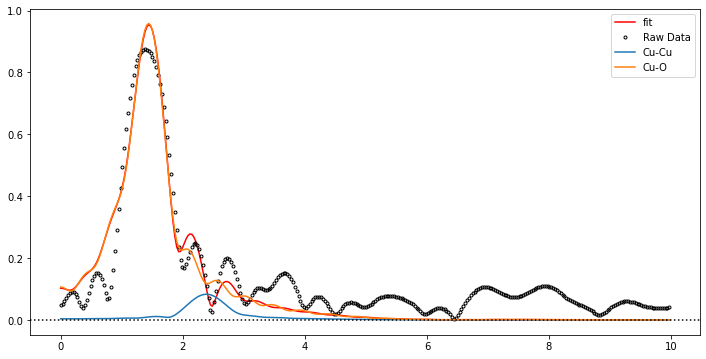

In [14]:
""" Misc: Plotting fitted results"""

data_r = _feffit_dataset.data.r
data_chir_mag = _feffit_dataset.data.chir_mag

fit_r = _feffit_result.datasets[0].model.r
fit_chir_mag = _feffit_result.datasets[0].model.chir_mag

a = _feffit_result.datasets[0].paths["Cu256"].r
b = _feffit_result.datasets[0].paths["Cu256"].chir_mag

c = _feffit_result.datasets[0].paths["O195"].r
d = _feffit_result.datasets[0].paths["O195"].chir_mag

fig = plt.figure(figsize=(12, 6))
plt.plot(fit_r, fit_chir_mag, color="r", label="fit")
plt.plot(data_r, data_chir_mag, lw=0, marker='o', markersize=3, fillstyle='none', color="k", label="Raw Data")
plt.plot(a, b, label="Cu-Cu")
plt.plot(c, d, label="Cu-O")
plt.axhline(0, color="k", linestyle=":")
plt.legend()

In [6]:
""" Misc: Print fitted results. """
print(feffit_report(_feffit_result))

=================== FEFFIT RESULTS ====================
[[Statistics]]
   nvarys, npts       =  7, 196
   n_independent      =  14.369
   chi_square         =  122.504439
   reduced chi_square =  16.6242619
   r-factor           =  0.12284543
   Akaike info crit   =  44.7938499
   Bayesian info crit =  49.4493691
 
[[Data]]
   fit space          = 'r'
   r-range            = 1.000, 4.000
   k-range            = 3.000, 10.000
   k window, dk       = 'hanning', 1.000
   paths used in fit  = ['C:/Users/user/larch/feff/Cu1_K_Copper_cif11145/feff0001.dat', 'C:/Users/user/larch/feff/Cu1_K_Tenorite_cif11639/feff0001.dat']
   k-weight           = 2
   epsilon_k          = Array(mean=0.00463655, std=0.00577351)
   epsilon_r          = 0.04131062
   n_independent      = 14.369
 
[[Variables]]
   delr_Cu        =  0.00505104 +/- 0.07020819   (init=  1.0000e-03)
   delr_O         = -0.01395802 +/- 0.02974249   (init=  1.0000e-03)
   e0             = -9.99999996 +/- 2.05443435   (init=  0.10000000)

In [ ]:
""" Misc: Extract fitted parameters. """
s02 = _feffit_result.paramgroup.s02
e0 = _feffit_result.paramgroup.e0
delr_Cu256 = _feffit_result.paramgroup.delr_Cu256
sigma2_Cu256 = _feffit_result.paramgroup.sigma2_Cu256

_feffit_result.datasets